In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Joins and Data Frame builds
## Goal is to separate health outcomes from unhealthy behaviors and preventative measures

In [4]:
data = pd.read_csv('data/cleansed/data.csv')
dataDef = pd.read_csv('data/cleansed/data_def.csv')
locations = pd.read_csv('data/cleansed/locations.csv')

In [5]:
data2 = data.set_index('uniqueid').join(locations.set_index('uniqueid')['geographiclevel']).copy()
data2 = data2[data2['geographiclevel'] == 'Census Tract']
data2 = data2.drop(['Unnamed: 0','datavaluetypeid','geographiclevel'],axis=1).reset_index()

In [6]:
dataMelt = data2.melt(id_vars=['uniqueid','populationcount'],var_name='measureid')

In [7]:
dataDef2 = dataDef[['measureid','category']].drop_duplicates()

In [8]:
joined = dataMelt.set_index('measureid').join(dataDef2.set_index('measureid'),rsuffix='_def',how='left').reset_index().set_index(['uniqueid','populationcount'])

In [9]:
preventative = joined[joined['category'] == 'Prevention'].copy()
outcomes = joined[joined['category'] == 'Health Outcomes'].copy()
unhealthy = joined[(joined['category'] == 'Unhealthy Behaviors') | (joined['category'] == 'Prevention')].copy()

In [10]:
unhealthypiv = unhealthy.reset_index().pivot_table('value','uniqueid','measureid',aggfunc=np.sum)

In [11]:
outcomespiv = outcomes.reset_index().pivot_table('value','uniqueid','measureid',aggfunc=np.sum)

## Create a clustermap of behaviors and health outcomes correlations to see if there are any correlations or groups of correlations that lead to certain outcomes

/Users/bharathkoneti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


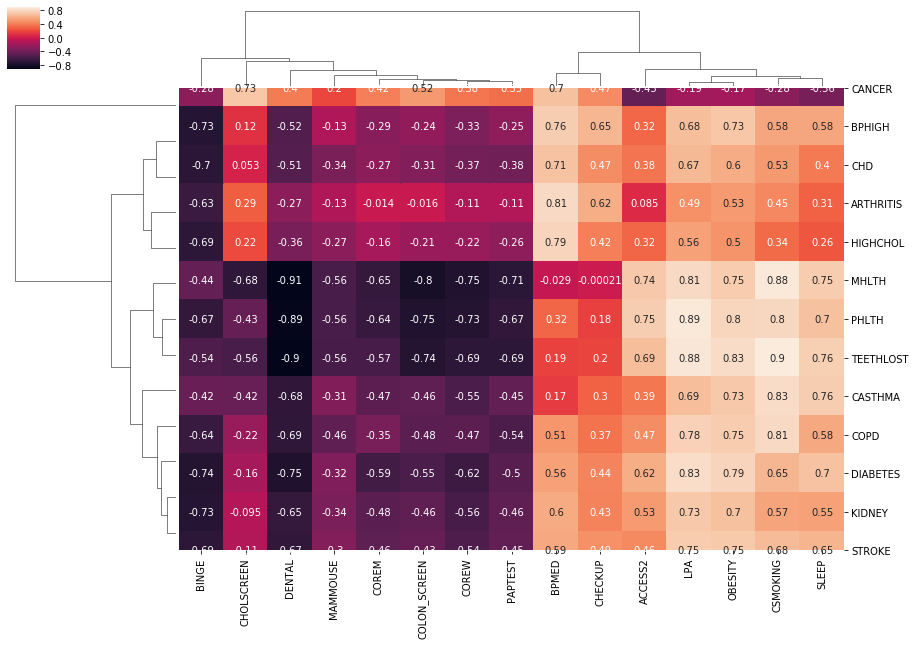

In [12]:
corrDF = []
for behavior in unhealthy.measureid.unique():
    analysis = outcomespiv.join(unhealthypiv[behavior]).copy()
    corrDF.append(analysis.corr()[behavior].to_frame())
cluster = sns.clustermap(pd.concat(corrDF,axis=1).dropna(),annot=True,figsize=(15,10))
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.show();

Some high level takeaways:

1.) taking part in preventative measures (columns CHOLSCREEN to and including BPMED) seems to show an inverse correlation to most health measures. There are two exceptions: 
    - Taking blood pressure medication is correlated with most health outcomes. This is probably because if someone is already taking BP medication they already have some health issues.
    - Preventative measures are somewhat correlated with incidences of cancer. This could be due to have screening means you catch the disease while not getting the screenings means you do not

2.) Binge drinking seems to be inversely correlated with all health outcomes. This comes as a surprise to me.
3.) Lack of sleep, Low physical activity, and having obesity all seem to highly correlate with health outcomes, especially poor mental health, physical health, and teeth loss.

I think there is some collinearity in LPA, Obesity, and C

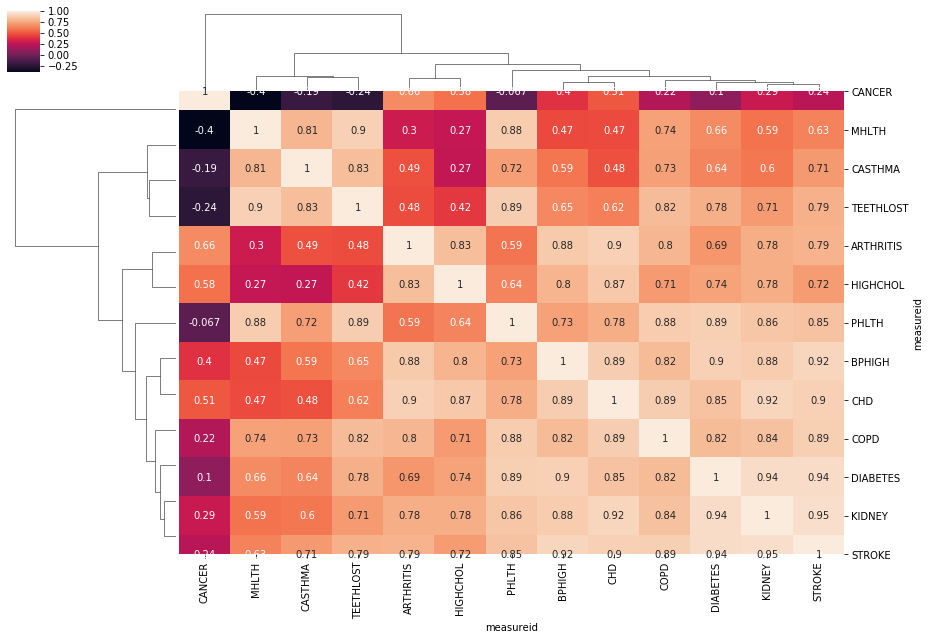

In [13]:

cluster = sns.clustermap(outcomespiv.corr(),annot=True,figsize=(15,10))
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.show();

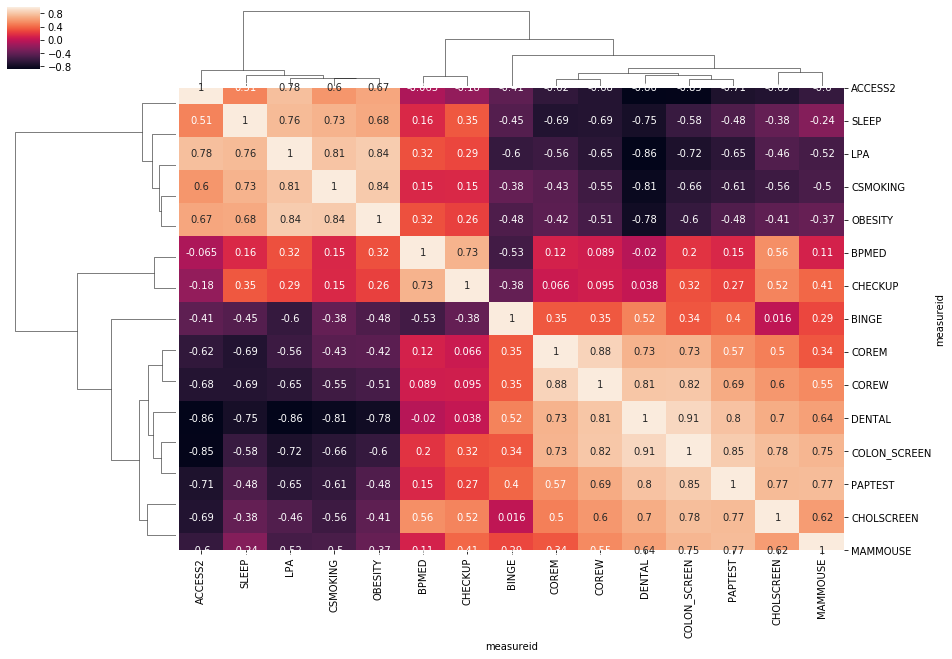

In [14]:

cluster = sns.clustermap(unhealthypiv.corr(),annot=True,figsize=(15,10))
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.show();

# Personally, I have a draw to predicting the Obesity rate of a given population. In the last 6 years, I've lost over 100lbs and would love to  better understand the risk factors of obesity as to speak more inteligently about it

# What is the histogram of Obesity? Is it normally distributed?
- It's not quite normal and has slight right skew.  Although about half of the census tracts have obesity rates of less than 30%, we'd like to see if we can figure out why there is a right skew

/Users/bharathkoneti/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


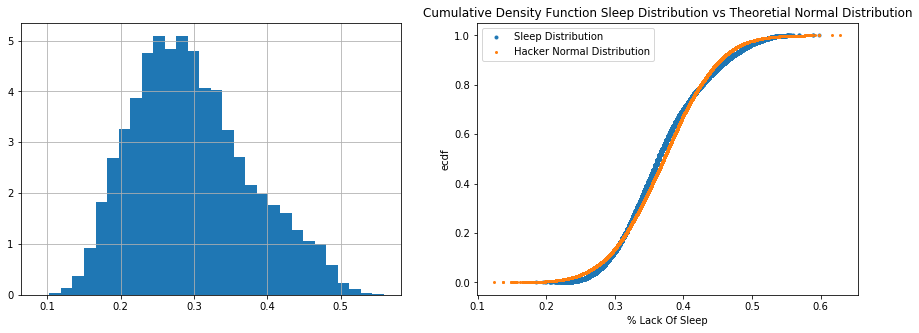

In [15]:
fig,[ax0,ax1] = plt.subplots(1,2,figsize=(15,5))
data2.OBESITY.hist(ax=ax0,bins=30,normed=True)
plt.title('Obesity Histogram',)


n = len(unhealthypiv.SLEEP)
x = unhealthypiv.SLEEP.sort_values()
y = np.arange(1,n+1)/n
x_theor = sorted(np.random.normal(x.mean(),x.std(),n))
ax1.plot(x,y,marker='.',linestyle='none',label='Sleep Distribution')
ax1.plot(x_theor,y,marker='.',linestyle='none',label='Hacker Normal Distribution',markersize=4)
plt.xlabel('% Lack Of Sleep')
plt.ylabel('ecdf')
plt.title('Cumulative Density Function Sleep Distribution vs Theoretial Normal Distribution')
plt.legend()
plt.show()

## From the heatmaps above, there seems to be some correlation between Obesity and other metrics  such as low physical activity (LPA) and smoking. Also, lack of sleep seems to correlate with LPA. What seems to be the most important factor in predicting obesity rates?

In [ ]:
## Define whether or not a certain sleep % falls within best 20%, worst 20%, or in the middle
def quant(x,y):
    if x < y[.2]:
        return 0
    elif x > y[.8]:
        return 2
    return 1

data2['sleepQuantile'] = data2.SLEEP.apply(lambda x: quant(x,data2.SLEEP.quantile([.2,.8])))
data2['lpaQuantile'] = data2.LPA.apply(lambda x: quant(x,data2.LPA.quantile([.2,.8])))
data2['csmokingQuantile'] = data2.CSMOKING.apply(lambda x: quant(x,data2.CSMOKING.quantile([.2,.8])))

#Plt the scatter plot of Low physical activity and Obesity separated by sleep quantiles
sns.lmplot('LPA','OBESITY',data=data2,col='sleepQuantile')
_ = plt.xlabel('LPA')
_ = plt.ylabel('OBESITY')
plt.show()

## When looking at the relationship between between LPA & Obesity, we see a very defined scatter plot of the two.

## Even more interesting is when looking populations that say they receive less sleep, we observe higher percentages of Low Physical Activity and Higher Percentages of Obesity

Definitions of sleepQuantile
- Quantile 0 = < Lowest 20% of populations reporting lack of sleep (Sleep enough)
- Quantile 1 = Middle 80% of populations
- Quantile 2 = Highest 20% of populations reporting lack of sleep

# Now I'd like to look at the histgrams of Obesity but broken out "quantile" of LPA and Sleep. Do we see different distributions of Obesity for different levels of activity?

In [ ]:
fig, [ax0,ax1,ax2] = plt.subplots(1,3,figsize=(15,5))

data2[data2['lpaQuantile']==0]['OBESITY'].hist(bins=50,ax=ax0)
ax0.set_title('Bottom 20% LPA Percentages (Less people report low activity)')
data2[data2['lpaQuantile']==1]['OBESITY'].hist(bins=50,ax=ax1)
ax1.set_title('Middle 80% LPA Percentages')
data2[data2['lpaQuantile']==2]['OBESITY'].hist(bins=50,ax=ax2)
ax2.set_title('>80% LPA Percentages (More people report low activity)')
plt.show()

## It seems that the histogram curve becomes more normal In the lower 20% and middle LPA percentages but we start seeing a left skew for populations with higher levels of low physical activity

## Do we see anything different among those with sleep issues?

In [ ]:
fig, [ax0,ax1,ax2] = plt.subplots(1,3,figsize=(15,5))

data2[data2['sleepQuantile']==0]['OBESITY'].hist(bins=50,ax=ax0)
ax0.set_title('<20% Sleep Issues (Less issues)')
data2[data2['sleepQuantile']==1]['OBESITY'].hist(bins=50,ax=ax1)
ax1.set_title('Middle 80% Sleep Issues')
data2[data2['sleepQuantile']==2]['OBESITY'].hist(bins=50,ax=ax2)
ax2.set_title('>80% Sleep Issues (Most Issues)')
plt.show()

## We see the same phenomenon in those reporting sleep issues as well

## What about with current smokers?

In [ ]:
fig, [ax0,ax1,ax2] = plt.subplots(1,3,figsize=(15,5))

data2[data2['csmokingQuantile']==0]['OBESITY'].hist(bins=50,ax=ax0)
ax0.set_title('<20% report currently smoking (Less % of popultion smokes)')
data2[data2['csmokingQuantile']==1]['OBESITY'].hist(bins=50,ax=ax1)
ax1.set_title('Middle 80% report currently smoking')
data2[data2['csmokingQuantile']==2]['OBESITY'].hist(bins=50,ax=ax2)
ax2.set_title('>80% report currently smoking (High % of popultion smokes)')
plt.show()

## We see the same phenomenon in those reporting high smoking rates, but it's not as dramatic.

# I'd like to make a hypothesis at this point. LPA is a strong indicator of Obesity and those activities that may raise the % of the population that has LPA will ultimately aid in raising the rate of people who are obese. 